# DATASET

In [148]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [149]:
dataset = DATASETS[32] # robo_net
display_key = 'image'

ds, iterator = get_dataset(dataset, display_key=display_key, )

FeaturesDict({
    'episode_metadata': FeaturesDict({
        'file_path': Text(shape=(), dtype=string),
        'robot': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(5,), dtype=float32),
        'discount': Scalar(shape=(), dtype=float32),
        'is_first': Scalar(shape=(), dtype=bool),
        'is_last': Scalar(shape=(), dtype=bool),
        'is_terminal': Scalar(shape=(), dtype=bool),
        'language_embedding': Tensor(shape=(512,), dtype=float32),
        'language_instruction': Text(shape=(), dtype=string),
        'observation': FeaturesDict({
            'image': Image(shape=(240, 320, 3), dtype=uint8),
            'image1': Image(shape=(240, 320, 3), dtype=uint8),
            'image2': Image(shape=(240, 320, 3), dtype=uint8),
            'state': Tensor(shape=(5,), dtype=float32),
        }),
        'reward': Scalar(shape=(), dtype=float32),
    }),
})


In [150]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-02-06 16:41:04.321815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:524: Filling up shuffle buffer (this may take a while): 20 of 30
2025-02-06 16:41:06.974730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [151]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE

1) sawyer
2) baxter
3) kuka iiwa
4) franka panda
5) widowx
6) fetch
7) google r3

In [152]:
iter_steps = iter(episode['steps'])
states = [base['observation']['state'] for base in iter_steps]

iter_steps = iter(episode['steps'])
actions = [action['action'] for action in iter_steps]

robot_name = episode['episode_metadata']['robot'].numpy().decode('utf-8')

In [153]:
robot_name

'baxter'

# ENV

In [157]:
r2d = {
    'sawyer': '../mujoco_menagerie/rethink_robotics_sawyer/scene_robonet.xml',
    'baxter': '../mujoco_menagerie/baxter/baxter_w_table.xml',
    'kuka iiwa': '../mujoco_menagerie/kuka_iiwa/scene.xml',
    'franka panda': '../mujoco_menagerie/franka_panda/scene.xml',
    'widowx': '../mujoco_menagerie/trossen_wx250s/scene_robonet.xml',
    'fetch': '../mujoco_menagerie/fetch/scene.xml',
    'google r3': '../mujoco_menagerie/google_robot/scene.xml'
}


xml_path = r2d[robot_name]
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL

In [65]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names[:-2] # Except fingers

# Don't Know Why.....
q0 = np.array( [-0.2639457174606611,
                0.0831913360274175,
                0.5017611504652179,
                1.156859026208673,
                0.028583671314766423,
                1.592598203487462,
                -1.080652960128774])


# q0 = np.zeros(len(joint_names), dtype=float)
p0 = env.get_p_body(body_name='base_link')+np.array([0.5,0.0,0.45])
R0 = rpy_deg2r([0,0,0])

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),
        joint_names = joint_names+['joint_finger_right','joint_finger_left'])
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Trajectory

### 1) genration

In [158]:
def trans_xyz(pos, scales=None, translations=None):
    if scales is None:
        scales = [0.4, 0.4, 0.4]
    if translations is None:
        translations = [0.5, 0, 0]

    # Convert input list to numpy array if needed
    pos = np.array(pos)
    
    # Transform each coordinate
    transformed = [
        pos[0] * scales[0] + translations[0],
        pos[1] * scales[1] + translations[1], 
        pos[2] * scales[2] + translations[2]
    ]
    
    return transformed

In [160]:
env.joint_names

['head_pan',
 'right_s0',
 'right_s1',
 'right_e0',
 'right_e1',
 'right_w0',
 'right_w1',
 'right_w2',
 'r_gripper_l_finger_joint',
 'r_gripper_r_finger_joint',
 'left_s0',
 'left_s1',
 'left_e0',
 'left_e1',
 'left_w0',
 'left_w1',
 'left_w2',
 'l_gripper_l_finger_joint',
 'l_gripper_r_finger_joint',
 'box']

In [159]:
joint_names = env.joint_names
q0 = np.zeros(len(joint_names), dtype=float)

q_traj = list()

q_ik_init = q0.copy()
for ik_target in states:
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = env.joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = trans_xyz(ik_target[:3].numpy()),
        R_trgt             = rpy2r(np.array([0,0, -ik_target[3].numpy()])),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    q_traj.append(qpos)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

### 2) Comparing

In [86]:
# G -> B -> R

idx = 0
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer()

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

: 

# Trajectory Reappearance

In [129]:
joint_names = env.joint_names

q0 = q_traj[0]

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.1):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


# Reverse Engineering

In [69]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = base_tool_poses[idx-1][3:]
target = quat2r(target)

base = env.get_R_body(body_name='link_gripper')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[0.81599899 0.07140578 0.274555   0.50365307]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'

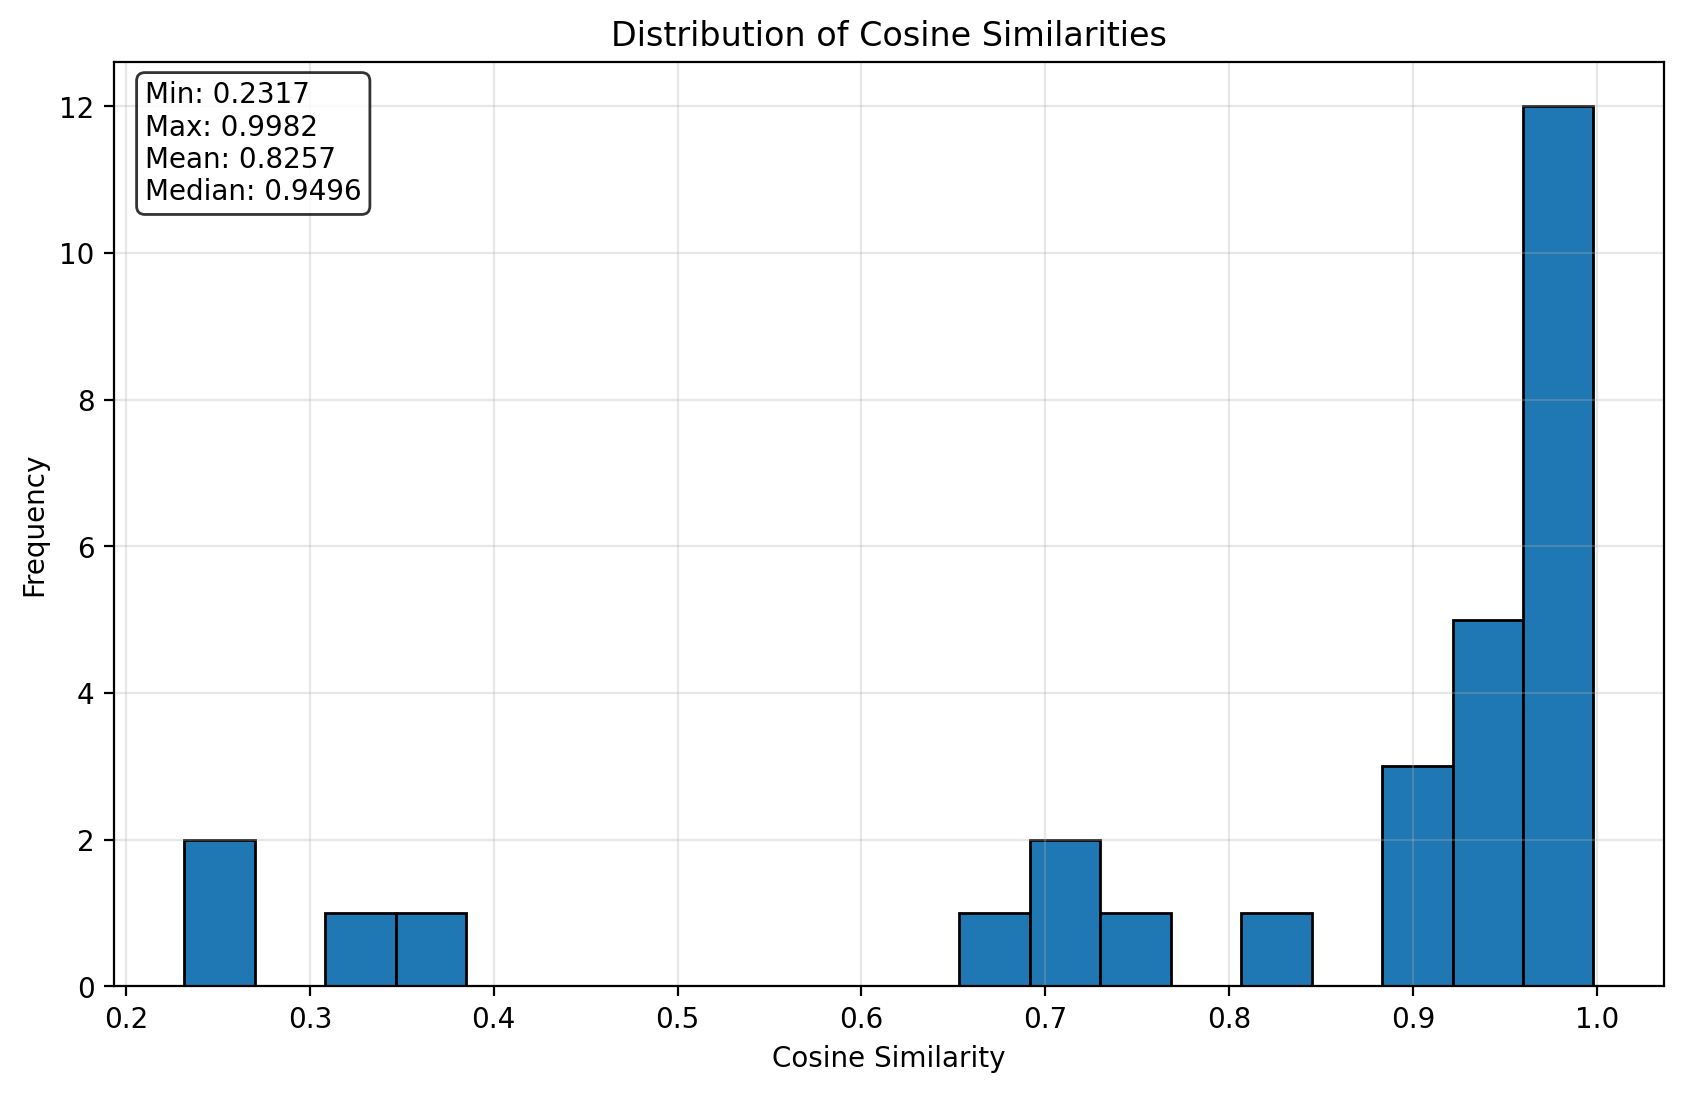

In [126]:
eef_delta = np.array(states[1:]) - np.array(states[:-1])

# Extract position components (indices 0,1,2) from eef_delta and actions
eef_pos_delta = eef_delta[:,:3]
action_pos = np.array([action[:3] for action in actions[:-1]])  # actions[:-1] to match length of eef_delta

# Calculate cosine similarity
# Calculate cosine similarity for each index
similarities = []
for i in range(len(eef_pos_delta)):
    similarity = np.sum(eef_pos_delta[i] * action_pos[i]) / (np.linalg.norm(eef_pos_delta[i]) * np.linalg.norm(action_pos[i]))
    similarities.append(similarity)

similarity = np.array(similarities)
# print(f"Cosine similarity between position deltas and actions: {similarity}")

# Calculate and print statistics of similarity values
# Plot histogram of similarity values
plt.figure(figsize=(10, 6))
plt.hist(similarity, bins=20, edgecolor='black')
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Add statistics as text annotation
stats_text = f'Min: {np.min(similarity):.4f}\nMax: {np.max(similarity):.4f}\n'
stats_text += f'Mean: {np.mean(similarity):.4f}\nMedian: {np.median(similarity):.4f}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.show()


In [51]:
len(frames)

30